## Spacenet

300x300 sized images - instead of 900 x 900


In [49]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [50]:
import datetime
import uuid

In [51]:
import PIL.Image as pil_image

In [52]:
from fastai import *
from fastai.vision import *

In [53]:
from fastai.utils import *
import fastai
print(fastai.__version__)

1.0.36.dev0


In [54]:
torch.cuda.set_device(0)

In [55]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
print(f'DATE: {DATE}') 

DATE: 20181218


In [56]:
UID=str(uuid.uuid4())[:8]
print(f'UID: {UID}') 

UID: ba2a2703


In [57]:
ARCH = models.resnet34
ARCH_NAME = 'rn34'
MODEL_NAME = '300_unet'

## Load Data

In [58]:
#using HD here
path = Path('../../data/SpaceNet_Off-Nadir_Dataset')
path.ls()

[PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/predicted_masks_300_2'),
 PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/SpaceNet-Off-Nadir_Test'),
 PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/SpaceNet-Off-Nadir_Train'),
 PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/resized_masks_300'),
 PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/test_data'),
 PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/resized_train'),
 PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/masks'),
 PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/SpaceNet-Off-Nadir_Sample'),
 PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/training_chip_ids.npy'),
 PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/predicted_masks_300_h2'),
 PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/resized_masks'),
 PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/resized_train_300'),
 PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/band-triplets.txt'),
 PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/SpaceNet-Off-Nadir_Sa

In [59]:
path_img = path/'resized_train_300'
path_lbl = path/'resized_masks_300'
path_test = path/'resized_test_300'

In [ ]:
pred_masks_1 = path/'predicted_masks_300_1'
pred_masks_2 = path/'predicted_masks_300_2'
pred_masks_3 = path/'predicted_masks_300_3'
pred_masks_4 = path/'predicted_masks_300_4'

In [61]:
fnames = get_image_files(path_img)
lbl_names = get_image_files(path_lbl)
test_fnames = get_image_files(path_test)
fnames[:3], lbl_names[:3] 

([PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/resized_train_300/Pan-Sharpen_Atlanta_nadir19_catid_1030010003C92000_740801_3734589_g_0.png'),
  PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/resized_train_300/Pan-Sharpen_Atlanta_nadir46_catid_1030010003713C00_747551_3723339_g_6.png'),
  PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/resized_train_300/Pan-Sharpen_Atlanta_nadir50_catid_10300100039E6200_748451_3727389_g_7.png')],
 [PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/resized_masks_300/mask_734051_3741789_g_0.png'),
  PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/resized_masks_300/mask_748451_3741789_g_2.png'),
  PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/resized_masks_300/mask_741251_3742239_g_0.png')])

In [62]:
len(fnames), len(lbl_names)

(258552, 9576)

In [63]:
def get_y_fn(full_name):
    parts = str(full_name).split('_')
    im_id = '_'.join(parts[-4:])
    mask_name = 'mask_'+im_id
    return path_lbl/f'{mask_name}'

In [64]:
#problem image/mask match:

#739001_3724239

In [65]:
img_f = fnames[-1]
img = open_image(img_f)
mask_f = get_y_fn(img_f)
mask = open_mask(mask_f, div=True)
print(f'img: {img_f}, mask: {mask_f}')


img: ../../data/SpaceNet_Off-Nadir_Dataset/resized_train_300/Pan-Sharpen_Atlanta_nadir14_catid_10300100039AB000_744401_3726039_g_5.png, mask: ../../data/SpaceNet_Off-Nadir_Dataset/resized_masks_300/mask_744401_3726039_g_5.png


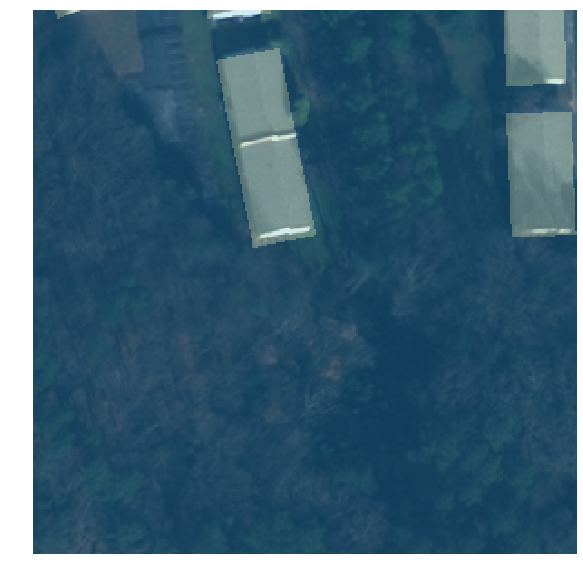

In [66]:
fig,ax = plt.subplots(1,1, figsize=(10,10))
img.show(ax=ax)
mask.show(ax=ax, alpha=0.5)

In [67]:
src_size = np.array(mask.shape[1:])
print(src_size)
mask.data

[300 300]


tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])

# Make DataBunch

In [68]:
size = src_size
bs=4

In [69]:
#holdout_grids = ['735851','747551','741251','746201']
#valid_idx = [i for i,o in enumerate(fnames) if any(c in str(o) for c in holdout_grids)]

In [70]:
codes = np.array(['nadir','offnadir','faroffnadir'])

In [71]:
# subclassing SegmentationLabelList to set open_mask(fn, div=True), probably a better way to do this?
# idea from https://forums.fast.ai/t/unet-binary-segmentation/29833/40

class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)
    
class SegItemListCustom(ImageItemList):
    _label_cls = SegLabelListCustom

In [72]:
src = (SegItemListCustom.from_folder(path_img)
        #.split_by_idx(valid_idx)
        .random_split_by_pct(0.1)
        .label_from_func(get_y_fn, classes=codes))

In [73]:
tfms = get_transforms(flip_vert=True, max_warp=0, max_zoom=1.2, max_lighting=0.3)
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [74]:
data

ImageDataBunch;

Train: LabelList
y: SegLabelListCustom (232697 items)
[ImageSegment (1, 300, 300), ImageSegment (1, 300, 300), ImageSegment (1, 300, 300), ImageSegment (1, 300, 300), ImageSegment (1, 300, 300)]...
Path: ../../data/SpaceNet_Off-Nadir_Dataset/resized_train_300
x: SegItemListCustom (232697 items)
[Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300)]...
Path: ../../data/SpaceNet_Off-Nadir_Dataset/resized_train_300;

Valid: LabelList
y: SegLabelListCustom (25855 items)
[ImageSegment (1, 300, 300), ImageSegment (1, 300, 300), ImageSegment (1, 300, 300), ImageSegment (1, 300, 300), ImageSegment (1, 300, 300)]...
Path: ../../data/SpaceNet_Off-Nadir_Dataset/resized_train_300
x: SegItemListCustom (25855 items)
[Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300)]...
Path: ../../data/SpaceNet_Off-Nadir_Dataset/resized_train_300;

Test: None

In [75]:
data.valid_ds.items

array([PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/resized_train_300/Pan-Sharpen_Atlanta_nadir47_catid_10300100033C5200_736301_3720189_g_3.png'),
       PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/resized_train_300/Pan-Sharpen_Atlanta_nadir29_catid_1030010003315300_739001_3722439_g_3.png'),
       PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/resized_train_300/Pan-Sharpen_Atlanta_nadir7_catid_1030010003D22F00_740351_3723339_g_8.png'),
       PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/resized_train_300/Pan-Sharpen_Atlanta_nadir10_catid_1030010003993E00_743051_3727839_g_3.png'),
       ...,
       PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/resized_train_300/Pan-Sharpen_Atlanta_nadir10_catid_1030010003CAF100_745301_3732339_g_4.png'),
       PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/resized_train_300/Pan-Sharpen_Atlanta_nadir44_catid_1030010003CCD700_733151_3738189_g_4.png'),
       PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/resized_train_300/Pan-Sharp

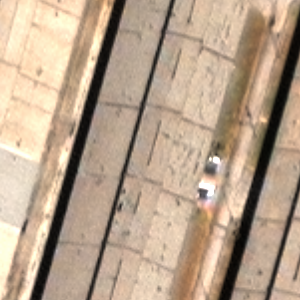

In [76]:
data.train_ds.x[1]

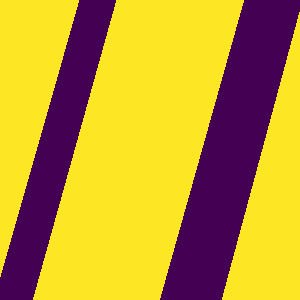

In [77]:
data.train_ds.y[1]

In [78]:
data.train_ds.y[1].data

tensor([[[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1]]])

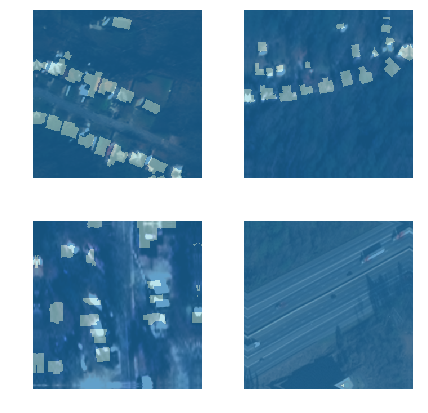

In [79]:
data.show_batch(2,figsize=(6,6), alpha=0.7)

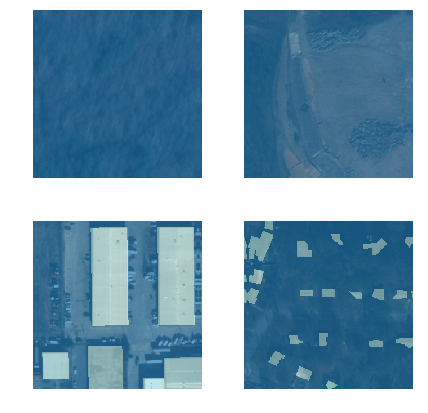

In [80]:
data.show_batch(2,figsize=(6,6), ds_type=DatasetType.Valid, alpha=0.7)

In [81]:
data.classes

array(['nadir', 'offnadir', 'faroffnadir'], dtype='<U11')

In [82]:
#### export for later use

In [83]:
data.export(fname=f'{DATE}_{UID}_{MODEL_NAME}_export.pkl')

# Custom Loss

In [84]:
import pdb

In [85]:
def dice_loss(input, target):
#     pdb.set_trace()
    smooth = 1.
    input = input[:,1,None].sigmoid()
    iflat = input.contiguous().view(-1).float()
    tflat = target.view(-1).float()
    intersection = (iflat * tflat).sum()
    return (1 - ((2. * intersection + smooth) / ((iflat + tflat).sum() +smooth)))

def combo_loss(pred, targ):
    bce_loss = CrossEntropyFlat(axis=1)
    return bce_loss(pred,targ) + dice_loss(pred,targ)

## Define Model

In [86]:
def acc_fixed(input, targs):
    n = targs.shape[0]
    targs = targs.squeeze(1)
    targs = targs.view(n,-1)
    input = input.argmax(dim=1).view(n,-1)
    return (input==targs).float().mean()

def acc_thresh(input:Tensor, target:Tensor, thresh:float=0.5, sigmoid:bool=True)->Rank0Tensor:
    "Compute accuracy when `y_pred` and `y_true` are the same size."
    
#     pdb.set_trace()
    if sigmoid: input = input.sigmoid()
    n = input.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    target = target.view(n,-1)
    return ((input>thresh)==target.byte()).float().mean()

In [87]:
# iou = partial(dice, iou=True)
metrics = [dice_loss, acc_thresh, dice]

In [88]:
learn = unet_learner(data, ARCH, metrics=metrics)

In [89]:
learn.loss_func

In [90]:
learn.loss_func = combo_loss
learn.loss_func

<function __main__.combo_loss(pred, targ)>

In [91]:
# learn.opt_func = partial(optim.SGD,momentum=0.9)

In [92]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


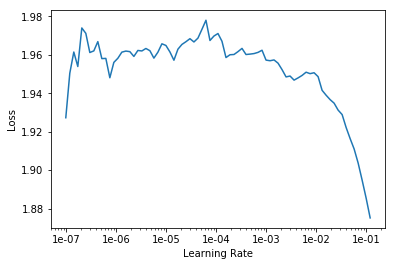

In [93]:
learn.recorder.plot(0,0)

In [94]:
lr = 1e-3

In [95]:
from fastai.callbacks import *

# small change to SaveModelCallback() to add printouts
@dataclass
class SaveModelCallbackVerbose(TrackerCallback):
    "A `TrackerCallback` that saves the model when monitored quantity is best."
    every:str='improvement'
    name:str='bestmodel'
    def __post_init__(self):
        if self.every not in ['improvement', 'epoch']:
            warn(f'SaveModel every {self.every} is invalid, falling back to "improvement".')
            self.every = 'improvement'
        super().__post_init__()

    def on_epoch_end(self, epoch, **kwargs:Any)->None:
        if self.every=="epoch": self.learn.save(f'{self.name}_{epoch}')
        else: #every="improvement"
            current = self.get_monitor_value()
            if current is not None and self.operator(current, self.best):
                self.best = current
                self.learn.save(f'{self.name}')
                print(f'saved model at epoch {epoch} with {self.monitor} value: {current}')

    def on_train_end(self, **kwargs):
        if self.every=="improvement": self.learn.load(f'{self.name}')

In [96]:
learn.fit_one_cycle(5, max_lr=lr, 
                    callbacks=[
                        SaveModelCallbackVerbose(learn,
                                                 monitor='dice',
                                                 mode='max',
                                                 name=f'{DATE}-{ARCH_NAME}-{MODEL_NAME}-comboloss-best-{UID}')
                    ]
                   )

epoch,train_loss,valid_loss,dice_loss,acc_thresh,dice
1,0.615911,0.560801,0.394789,0.939534,0.599729
2,0.610282,0.558599,0.387030,0.939918,0.563729
3,0.578054,0.530427,0.367070,0.941496,0.628068
4,0.532871,0.487061,0.338843,0.945290,0.622861
5,0.513572,0.470542,0.328684,0.948316,0.649776


saved model at epoch 1 with dice value: 0.5997294783592224
saved model at epoch 3 with dice value: 0.6280684471130371
saved model at epoch 5 with dice value: 0.6497764587402344


In [97]:
learn.load(f'{DATE}-{ARCH_NAME}-{MODEL_NAME}-comboloss-best-{UID}')
learn.model.eval()

DynamicUnet(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (re

In [98]:
outputs = learn.pred_batch(ds_type=DatasetType.Valid)

In [99]:
outputs.shape

torch.Size([4, 3, 300, 300])

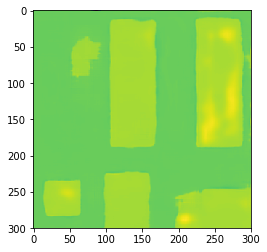

In [100]:
plt.imshow((to_np(outputs[2][1])))

In [101]:
outputs[2][1].sigmoid()

tensor([[5.2363e-04, 1.1569e-03, 7.6620e-04,  ..., 7.9881e-04, 8.0130e-04,
         6.5878e-04],
        [5.0033e-04, 1.4233e-03, 1.0009e-03,  ..., 1.3561e-03, 2.0611e-03,
         2.2745e-03],
        [2.7367e-04, 3.9019e-04, 3.7217e-04,  ..., 8.1936e-04, 9.2116e-04,
         7.5356e-04],
        ...,
        [9.3742e-04, 1.3388e-03, 9.3398e-04,  ..., 9.9969e-01, 9.9944e-01,
         9.9904e-01],
        [1.3365e-03, 2.0840e-03, 1.1129e-03,  ..., 9.9944e-01, 9.9877e-01,
         9.9754e-01],
        [1.1792e-03, 1.9493e-03, 1.0538e-03,  ..., 9.9935e-01, 9.9860e-01,
         9.9764e-01]])

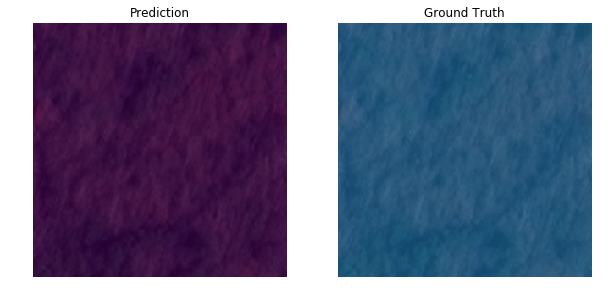

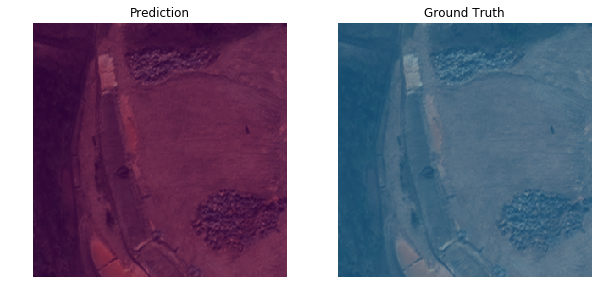

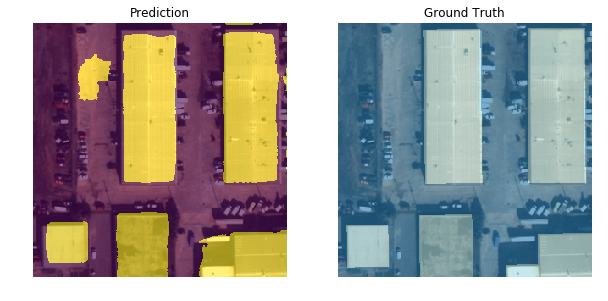

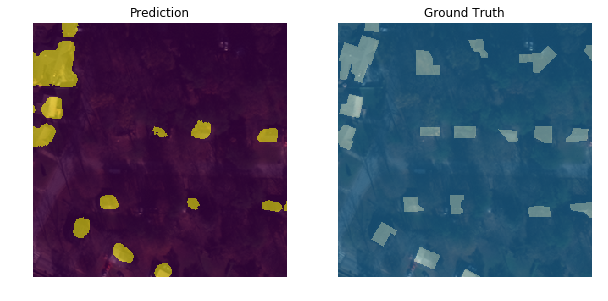

In [102]:
for i in range(bs):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

    data.valid_ds.x[i].show(ax=ax1)
    ax1.set_title('Prediction')
    ax1.imshow((to_np(outputs[i][1].sigmoid())>0.95), alpha=0.6)
    
    ax2.set_title('Ground Truth')
    data.valid_ds.x[i].show(ax=ax2)
    data.valid_ds.y[i].show(ax=ax2, alpha=0.6)
    plt.show()

In [103]:
print('predicting test images 1')
for tn in test_fnames:
    img = open_image(tn)
    pred_c,pred_idx,outputs=learn.predict(img)
    fn = tn.name
    pred_c.save(pred_masks_1/f'{fn}')

predicting test images 1


## Unfreeze and Train More

In [104]:
learn.model.train()

DynamicUnet(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (re

In [105]:
learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


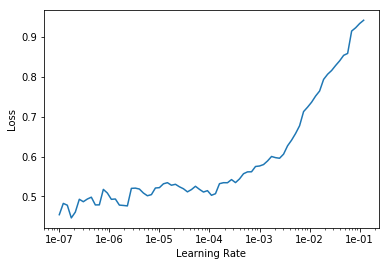

In [106]:
learn.recorder.plot(0,0)

In [107]:
lr = 1e-3

In [108]:
learn.fit_one_cycle(5, max_lr=slice(1e-6,lr/10), 
                    callbacks=[
                        SaveModelCallbackVerbose(learn,
                                                 monitor='dice',
                                                 mode='max',
                                                 name=f'{DATE}-{ARCH_NAME}-{MODEL_NAME}-comboloss-unfreeze-1-best-{UID}')
                    ]
                   )

epoch,train_loss,valid_loss,dice_loss,acc_thresh,dice
1,0.509016,0.463234,0.323232,0.948311,0.661093
2,0.527677,0.460360,0.322606,0.948808,0.646819
3,0.504813,0.460406,0.321488,0.949160,0.673504
4,0.475900,0.455827,0.317024,0.947121,0.666528
5,0.477107,0.451389,0.314348,0.949613,0.668423


saved model at epoch 1 with dice value: 0.6610926389694214
saved model at epoch 3 with dice value: 0.6735040545463562


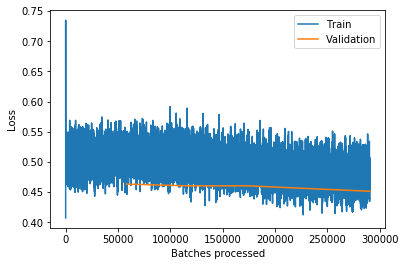

In [109]:
learn.recorder.plot_losses()

In [110]:
#save model after these n epochs
learn.save(f'{DATE}-{ARCH_NAME}-{MODEL_NAME}-comboloss-unfreeze-5-epochs-{UID}')
        

In [ ]:
learn.model.eval()

In [ ]:
print('predicting test images 2')
for tn in test_fnames:
    img = open_image(tn)
    pred_c,pred_idx,outputs=learn.predict(img)
    fn = tn.name
    pred_c.save(pred_masks_2/f'{fn}')

In [111]:
learn.fit_one_cycle(5, max_lr=slice(1e-6,lr/10), 
                    callbacks=[
                        SaveModelCallbackVerbose(learn,
                                                 monitor='dice',
                                                 mode='max',
                                                 name=f'{DATE}-{ARCH_NAME}-{MODEL_NAME}-comboloss-unfreeze-2-best-{UID}')
                    ]
                   )

epoch,train_loss,valid_loss,dice_loss,acc_thresh,dice
1,0.514794,0.453164,0.316967,0.949006,0.668818
2,0.476962,0.447326,0.312787,0.949266,0.664061
3,0.473474,0.468041,0.320672,0.949151,0.660209
4,0.451829,0.449669,0.309278,0.950873,0.684113
5,0.485957,0.440026,0.304771,0.951038,0.685431


saved model at epoch 1 with dice value: 0.668817937374115
saved model at epoch 4 with dice value: 0.6841132640838623
saved model at epoch 5 with dice value: 0.6854313611984253


In [112]:
#save model after these n epochs
learn.save(f'{DATE}-{ARCH_NAME}-{MODEL_NAME}-comboloss-unfreeze-10-epochs-{UID}')

In [113]:
learn.model.eval()

DynamicUnet(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (re

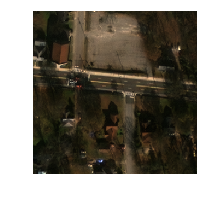

In [114]:
img = open_image(test_fnames[600])
img.show()
plt.show()

In [115]:
pred_c,pred_idx,outputs=learn.predict(img)

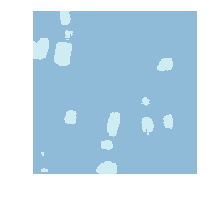

In [116]:
pred_c.show()

In [117]:
print('predicting test images 3')
for tn in test_fnames:
    img = open_image(tn)
    pred_c,pred_idx,outputs=learn.predict(img)
    fn = tn.name
    pred_c.save(pred_masks_3/f'{fn}')

predicting test images 2


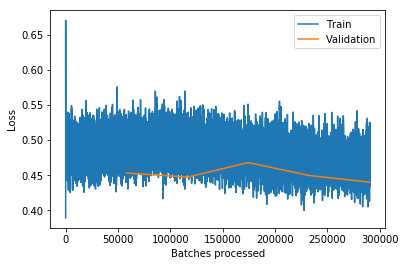

In [118]:
learn.recorder.plot_losses()

In [119]:
outputs = learn.get_preds(ds_type=DatasetType.Valid)

RuntimeError: CUDA out of memory. Tried to allocate 131.88 MiB (GPU 0; 10.91 GiB total capacity; 7.69 GiB already allocated; 79.69 MiB free; 1.22 GiB cached)

In [ ]:
outputs[0][0][1].squeeze(0).shape

In [ ]:
plt.imshow((to_np(outputs[0][0][1].squeeze(0))))

In [ ]:
outputs[0][0][1].squeeze(0).sigmoid()

In [ ]:
for i in range(bs*2):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

    data.valid_ds.x[i].show(ax=ax1)
    ax1.set_title('Prediction')
    ax1.imshow((to_np(outputs[0][i][1].squeeze(0).sigmoid())>0.95), alpha=0.6)
    
    ax2.set_title('Ground Truth')
    data.valid_ds.x[i].show(ax=ax2)
    data.valid_ds.y[i].show(ax=ax2, alpha=0.6)
    plt.show()

In [ ]:
for i in range(bs*2):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

    data.valid_ds.x[i].show(ax=ax1)
    ax1.set_title('Prediction')
    ax1.imshow((to_np(outputs[0][i][1].squeeze(0).sigmoid())), alpha=0.6)
    
    ax2.set_title('Ground Truth')
    data.valid_ds.x[i].show(ax=ax2)
    data.valid_ds.y[i].show(ax=ax2, alpha=0.6)
    plt.show()

In [ ]:
print(f'{DATE}_{UID}_{MODEL_NAME}')